In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

Initialize plotting

In [9]:
matplotlib.rcParams["svg.fonttype"] = "none"
plt.rcParams.update({"font.family": "Helvetica Neue"})
cm = 1 / 2.54  # centimeters in inches
colors = sns.color_palette("tab10", n_colors=2)

tmp = ['#0066B0', '#E8555F']
two_colors = []
for c in tmp:
    two_colors.append(matplotlib.colors.to_rgb(c))

colors_eight = sns.color_palette("tab20", n_colors=len(category_names))
colors_eight.reverse()

In [4]:
# Load data with regional volumes
df = pd.read_csv('data.csv')
# Print summary
df.iloc[:, 4:].head()

,site_num,CNV,genetic_stat2,age_spm,sex,volume,Front_Pole,Insula,Sup_Front_Gyr,Mid_Front_Gyr,...,I-IV_Cerebellum,V_Cerebellum,VI_Cerebellum,Crus_I_Cerebellum,Crus_II_Cerebellum,VIIb_Cerebellum,VIIIa_Cerebellum,VIIIb_Cerebellum,IX_Cerebellum,X_Cerebellum
570,6.0,15q11.2,deletion,55.0,0.0,587914.0,-0.074164,0.019909,0.001225,0.114149,...,-0.146308,-0.053500,0.016681,0.020838,0.046743,-0.067465,-0.027757,0.045679,-0.104263,0.076513
571,6.0,15q11.2,deletion,48.0,0.0,592574.0,-0.184549,0.030302,0.159501,0.230422,...,0.007876,0.100267,0.021185,0.047022,0.093325,-0.146724,0.019252,-0.100824,-0.082475,-0.039452
572,6.0,15q11.2,deletion,66.0,1.0,611745.0,-0.144978,0.122321,0.275197,0.156425,...,-0.125297,0.013399,0.095192,-0.103760,0.159400,0.082095,0.079173,0.462184,-0.148444,0.159370
573,7.0,15q11.2,deletion,44.0,1.0,627202.0,-0.037130,0.056873,0.122030,0.133258,...,-0.139433,0.006227,-0.042850,0.082768,-0.008729,-0.040657,0.112364,0.180582,-0.065167,0.395848
574,6.0,15q11.2,deletion,60.0,1.0,602985.0,-0.073699,0.026477,0.296261,0.252428,...,-0.283510,-0.072724,0.042752,-0.047456,-0.044656,-0.008032,0.014380,0.071450,-0.052110,-0.029071


In [7]:
# Dataframe with only CNVs
df_mutsubs = df[df.CNV != "Control"]
df_controls = df[df.CNV == "Control"]

scaler = StandardScaler()

# Arrays with brain volumes
X_full = np.array(df.iloc[:, 10:])
X_ctrl = X_full[df.CNV == "Control"]
X_mut = X_full[df.CNV != "Control"]
X_full_ss = scaler.fit_transform(X_full)
X_ctrl_ss = scaler.fit_transform(X_ctrl)
X_mut_ss = scaler.transform(X_mut)

Classification targets

In [10]:
category_names = ["1q21.1del", "1q21.1dup", "15q11.2del", "15q11.2dup",
                  "16p11.2del", "16p11.2dup", "22q11.2del", "22q11.2dup"]

target_mut = df_mutsubs.CNV.map({"1q21.1": 0, "16p11.2": 1, "22q11.2": 2})
y_mut = df_mutsubs.genetic_stat2.map({"deletion": 0, "duplication": 1})

y = np.array(y_mut + (target_mut * 2))

Violin plot of selected region

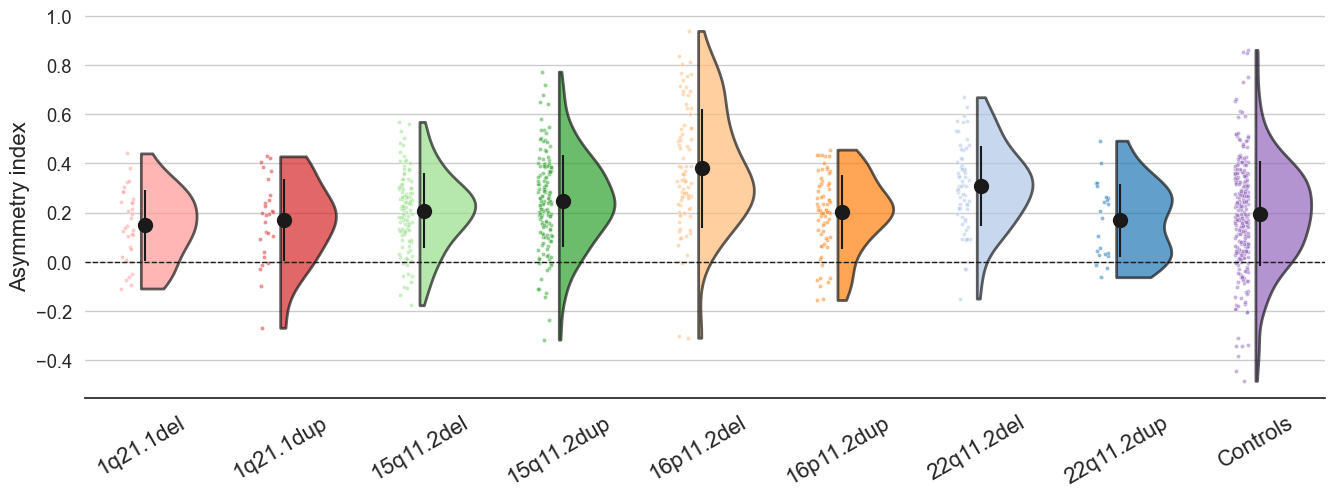

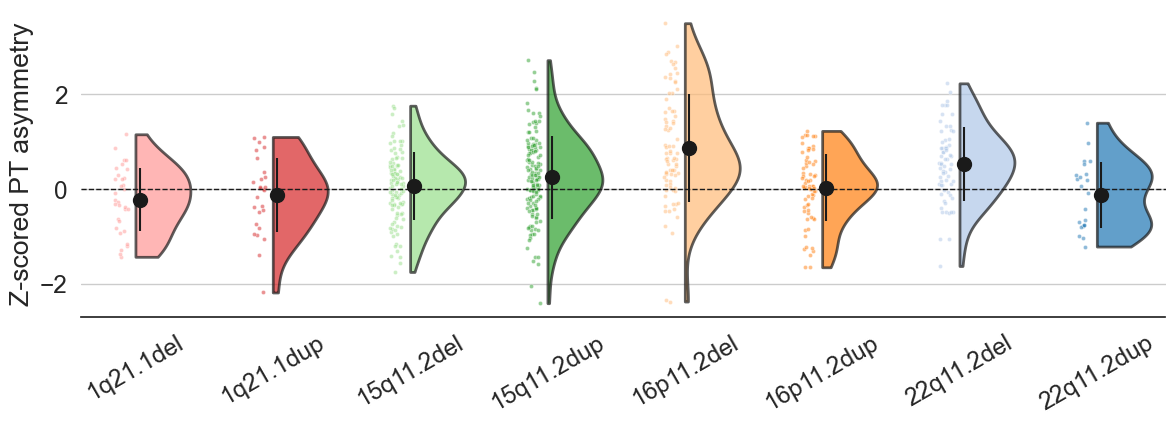

In [2]:
reg = 45  # planum temporale
X_ai_ctrl = []
X_ai_mut = []
for i, cat in enumerate(category_names):
    X_cnv = X_mut[y == i, :]
    X_star = np.concatenate((X_cnv, X_ctrl))
    scaler.fit(X_star)
    
    X_ctrl_ss = np.array(X_ctrl)
    X_cnv_ss = np.array(X_cnv)   
    X_ai_mut.append(X_cnv_ss[:, reg])
    X_ai_ctrl.append(X_ctrl_ss[:, reg])
    
X_ai_all = list(X_ai_mut)
X_ai_all.append(X_ai_ctrl[0]) 
X_ai_mut = np.concatenate(X_ai_mut)
X_ai_ctrl = X_ai_ctrl[0]
y_ctrl = np.ones(len(X_ai_ctrl))*8

d = pd.DataFrame({'score': np.concatenate((X_ai_mut, X_ai_ctrl)),
                  'stat': np.concatenate((y, y_ctrl))})
category_names_long = list(category_names)
category_names_long.append('Controls')
my_colors_long = list(colors_eight)
my_colors_long.append(tuple([0.5803921568627451, 0.403921568627451, 0.7411764705882353]))

# All CNVs and Contrls
sns.set_theme(style="white", palette='colorblind', font_scale=1.2)
fig, ax = plt.subplots(1, figsize=(16, 5))
# Plot violiplot
v1 = ax.violinplot(X_ai_all, vert=True, showextrema=False, points=5000, bw_method='scott',
                    widths=0.8)
for b,c in zip(v1['bodies'], my_colors_long):
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color(c)
    b.set_edgecolor('k')
    b.set_linewidth(2)
    b.set_alpha(0.7)
# Plot points on the left    
for n in range(len(category_names_long)):
    d = pd.DataFrame({'x': 0.1*np.random.uniform(size=len(X_ai_all[n]))+n+0.85,
                      'y': X_ai_all[n]})
    sns.scatterplot(data=d, x='x', y='y',
                    color=my_colors_long[n], 
                    marker='.', sizes=5, alpha=0.5)
# Plot mean and standard error
for n in range(len(category_names_long)):
    ax.errorbar(n+1.03, np.mean(X_ai_all[n]), yerr=np.sqrt(np.var(X_ai_all[n])), color='k')
    ax.plot(n+1.03, np.mean(X_ai_all[n]), 'k.', ms=20)
    
fontsize = 16
ax.set_ylabel('Asymmetry index', fontsize=fontsize)
ax.set_xlim([0.6, 9.5])
ax.set_xlabel('', fontsize=fontsize)
ax.set_xticks(np.arange(1, len(category_names_long)+1))
ax.set_xticklabels(category_names_long, fontsize=fontsize, rotation=30, horizontalalignment='center')
ax.set_title('', fontsize=fontsize+2)
sns.despine(left=True)
ax.yaxis.grid()
plt.axhline(y=0, linestyle='--', linewidth=1, color='k')
plt.show()

# z-score on controls
X_ai_mut = []
scaler.fit(X_ctrl)
for i, cat in enumerate(category_names):
    X_cnv = X_mut[y == i, :]
    X_cnv_ss = scaler.transform(X_cnv)   
    X_ai_mut.append(X_cnv_ss[:, reg])

X_ai_all = list(X_ai_mut)
X_ai_mut = np.concatenate(X_ai_mut)

d = pd.DataFrame({'score': X_ai_mut,
                  'stat': y})

sns.set_theme(style="white", palette='colorblind', font_scale=1.6)
fig, ax = plt.subplots(1, figsize=(14, 4))
# Plot violiplot
v1 = ax.violinplot(X_ai_all, vert=True, showextrema=False, points=5000, bw_method='scott',
                    widths=0.8)
for b,c in zip(v1['bodies'], colors_eight):
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color(c)
    b.set_edgecolor('k')
    b.set_linewidth(2)
    b.set_alpha(0.7)
# Plot points on the left    
for n in range(len(category_names)):
    d = pd.DataFrame({'x': 0.1*np.random.uniform(size=len(X_ai_all[n]))+n+0.85,
                      'y': X_ai_all[n]})
    sns.scatterplot(data=d, x='x', y='y',
                    color=colors_eight[n], 
                    marker='.', sizes=5, alpha=0.5)
# Plot mean and standard error
for n in range(len(category_names)):
    ax.errorbar(n+1.03, np.mean(X_ai_all[n]), yerr=np.sqrt(np.var(X_ai_all[n])), color='k')
    ax.plot(n+1.03, np.mean(X_ai_all[n]), 'k.', ms=20)
    
fontsize = 16
ax.set_ylabel('Z-scored PT asymmetry')
ax.set_xlim([0.6, 8.5])
ax.set_xlabel('')
ax.set_xticks(np.arange(1, len(category_names)+1))
ax.set_xticklabels(category_names, rotation=30, horizontalalignment='center')
ax.set_title('', fontsize=fontsize+2)
sns.despine(left=True)
ax.yaxis.grid()
plt.axhline(y=0, linestyle='--', linewidth=1, color='k')
plt.show()